Example code for loading loss data from the paper [Unified Scaling Laws for Routed Language Models](https://arxiv.org/abs/2202.01169). 

This is meant as a quick demonstration on how one can load the data and use it to fit some scaling laws we discuss in the paper, and not a detailed reproduction of the results.

See the repository's [Documentation Page](https://github.com/deepmind/scaling_laws_for_routing/) for a description of each field in the dataset.



In [ ]:
#@title Installation and imports
!pip install jax matplotlib numpy pandas seaborn scipy
import gzip
import jax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

In [ ]:
!wget https://github.com/deepmind/scaling_laws_for_routing/blob/main/data/curves.csv.gz .

In [ ]:
LOAD_PATH = 'curves.csv.gz'
with gzip.open(LOAD_PATH) as f:
  EVAL_LOSS = pd.read_csv(f)

In [5]:
# We will use jax for its autodiff features, but this is meant to run on the CPU.
# Note that for simplicity we are not assessing performance with cross
# validation.

def fit(fn,
        params_init: jnp.ndarray,
        ns: jnp.ndarray,
        es: jnp.ndarray,
        targets: jnp.ndarray,
        best_of_n: int = 10):
  """Fit a given function in log-space"""
  log_targets = jnp.log10(targets)
  @jax.jit
  def squared_error_objective(params):
    predicted = fn(ns, es, *params)
    log_predicted = jnp.log10(predicted)
    diff = jnp.square(log_targets - log_predicted).mean()
    return diff
  grad_objective = jax.jit(jax.grad(squared_error_objective), backend="cpu")
  best_result = None
  for _ in range(best_of_n):
    result = scipy.optimize.minimize(
        lambda x: np.asarray(squared_error_objective(x)),
        x0=(params_init * np.random.normal(size=params_init.shape)),
        jac=lambda x: np.asarray(grad_objective(x)).astype(np.float64),
        method="L-BFGS-B",
    )
    if best_result is None or result.fun < best_result.fun:
      best_result = result
  return best_result


# We're keeping the notation here consistent with the paper:
# log(loss) ~ a log(n) + b log(e_hat) + c log(n) log(e) + d  (Eq 1., page 5)
# n: parameter count
# e: expert count
# a,b,c,d: scaling law coefficients 
# e_hat: saturating transform on expert count
# e_start, e_max: parameters for the saturating transform

def saturating_transform(e, e_start, e_max):
  e_start = jnp.power(2, e_start)
  e_max = jnp.power(2, e_max)
  inverse = 1 / (e - 1 + 1 / (1/e_start - 1/e_max)) + 1/e_max
  return 1 / inverse

def bilinear_lines_tailoff(n, e, a, b, c, d, e_start, e_max):
  e_hat = saturating_transform(e, e_start, e_max)
  logterm = (a * jnp.log10(n) + b * jnp.log10(e_hat) + 
              c * jnp.log10(n) * jnp.log10(e_hat) + d)
  return jnp.power(10, logterm)

def effective_param_count(n, e, a, b, c, d, e_start, e_max):
  e_hat = saturating_transform(e, e_start, e_max)
  real_e_start = np.power(2, e_start)
  alpha_n = lambda x: a + c * np.log10(x)
  a_e = alpha_n(e_hat)
  a_1 = alpha_n(real_e_start)
  right = np.power(e_hat / real_e_start, b / a_1)
  left = np.power(n, a_e / a_1)
  epc = left * right
  return epc


In [6]:
# Let us select the data that we want to use for the plots below.
loss_at_final_step = EVAL_LOSS.sort_values('step').groupby('hyper_id').last()

curve_datapoints = loss_at_final_step.query(
    '(routing_frequency == 1/2) and (k == 1) and (seed ==  42)')
curve_datapoints = curve_datapoints.set_index('router_type')

dense_datapoints = curve_datapoints.loc['Dense']
routed_datapoints = curve_datapoints.loc[['S-Base', 'RL-R', 'Hash']]

In [7]:
# We will fit the parameters per router type, and get the fitted values 
# for plotting

# Setup initial values for the parameters (a, b, c, d, e_start, e_max)
params_init = np.asarray(
      [-0.01100865,  0.11597899,  -0.08367467, 1.0, 1.0, 9.99978226])

prediction_datapoints = []
for router_type, router_datapoints in routed_datapoints.groupby(level=0):
  
  # Add the dense datapoints to the routed data. We're assuming the dense 
  # models are equivalent to any router type with num_experts = 1 
  full_data = pd.concat([dense_datapoints, router_datapoints]).reset_index()
  full_data['router_type'] = router_type

  # Fit the curves based on parameter count and number of experts
  # The optimizer is reasonably fast so we fit 500 times.
  ns = jnp.array(full_data.dense_parameter_count)
  es = jnp.array(full_data.num_experts)
  loss = jnp.array(full_data.loss_validation)
  result = fit(
    bilinear_lines_tailoff, params_init, ns, es, loss, best_of_n=500)
  
  # Store the information we want
  full_data['effective_param_count'] = effective_param_count(ns, es, *result.x)
  full_data['fitted_loss'] = bilinear_lines_tailoff(ns, es, *result.x)
  prediction_datapoints.append(full_data)

prediction_datapoints = pd.concat(prediction_datapoints)

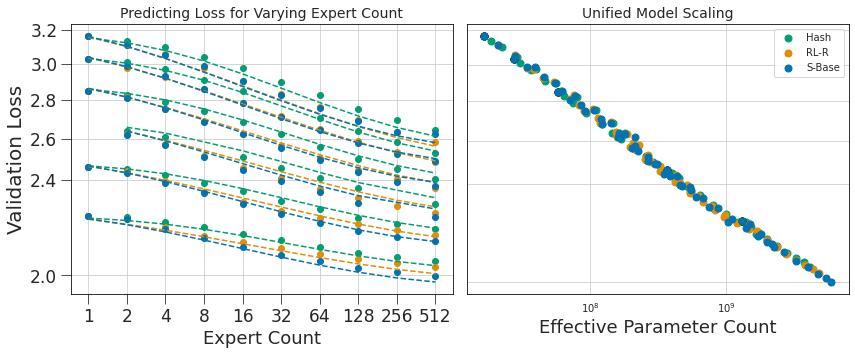

In [18]:
#@title Plot predictions
sns.set_style("whitegrid", {})

pallette = sns.color_palette("colorblind", 8)
colors = {
    "S-Base": pallette[0],
    "RL-R": pallette[1],
    "Hash": pallette[2],
}

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fig.subplots_adjust(wspace=0.35)

for ax in axs:
  ax.set_xscale("log")
  ax.set_yscale("log")
  for spine in ax.spines.values():
    spine.set_edgecolor("black")

for i, (router_type, per_router_df) in enumerate(
    prediction_datapoints.groupby("router_type")):
  color = colors[router_type]

  ax = axs[0]
  ax.set_title(
      "Predicting Loss for Varying Expert Count", fontdict={"fontsize": 14})

  for sz, df in per_router_df.groupby("model_size_label"):
    df = df.sort_values("num_experts")
    ax.plot(
        df.num_experts, df.fitted_loss, "--", color=color, label=router_type)
    ax.scatter(
        df.num_experts,
        df.loss_validation,
        marker="o",
        color=color,
        label=router_type)

  # Some axis formatting:
  ax.set_xticks([2**k for k in range(10)])
  ax.set_xticklabels([2**k for k in range(10)], fontsize=17)
  ax.tick_params(
      axis="x",
      bottom=True,
      direction="out",
      length=10,
  )
  ax.tick_params(
      axis="y",
      left=True,
      direction="out",
      length=10,
  )
  ax.set_yticks([2.0, 2.4, 2.6, 2.8, 3.0, 3.2])
  ax.set_yticklabels(
      [2.0, 2.4, 2.6, 2.8, 3.0, 3.2],
      fontsize=17,
  )
  ax.set_ylabel("Validation Loss", fontsize=20)
  ax.set_xlabel("Expert Count", fontsize=18)

  ax = axs[1]
  ax.set_title("Unified Model Scaling", fontdict={"fontsize": 14})
  ax.plot(
      dense_datapoints.dense_parameter_count,
      dense_datapoints.loss_validation,
      ".",
      marker="o",
      markersize=7,
      color="black")
  ax.plot(
      per_router_df.effective_param_count,
      per_router_df.loss_validation,
      ".",
      marker="o",
      markersize=7,
      color=color,
      label=router_type)
  ax.set_yticks([2.0, 2.4, 2.6, 2.8, 3.0, 3.2])
  ax.set_yticklabels([])
  ax.set_xlabel("Effective Parameter Count", fontsize=18)
axs[-1].legend()
fig.tight_layout()
None